In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.integrate import solve_ivp
plt.style.use('seaborn-darkgrid')
import datetime
from copy import deepcopy
from scipy.stats import norm

%config InlineBackend.figure_format = 'retina'

In [24]:
class DataFetcher:
    def __init__(self, url="https://api.covid19india.org/data.json"):
        self.url = url
        self.json_data = None
        self.cases_time_series = None
        
    def fetch(self):
        r = requests.get(url=self.url)
        self.json_data = r.json()
        
        # Get the fields
        fields = list(self.json_data['cases_time_series'][0].keys())
        self.cases_time_series = {}
        
        for field in fields:
            if field == 'date':
                self.cases_time_series[field] = [x[field] for x in self.json_data['cases_time_series']]
            else:
                self.cases_time_series[field] = np.array([float(x[field]) for x in self.json_data['cases_time_series']])
        
    def train_data(self, threshold):
        self.fetch()
        index = np.where(self.cases_time_series["totaldeceased"] > threshold)[0][0]
        startdate = self.cases_time_series["date"][index]
        return self.cases_time_series["totaldeceased"][index:], startdate

In [31]:
class DataFetcherState:
    """Fetch data for all states"""
    
    def __init__(self):
        self.data = None
        self.raw_data = None
    
    def fetch(self):
        # Fetch the raw data
        r = requests.get(url="https://api.covid19india.org/states_daily.json")
        self.raw_data = r.json()
        self.data = {}
        
        # Iterate over the days and record the data
        for entry in self.raw_data['states_daily']:
            status = entry['status'].lower()
            for state in entry:
                if state == "date" or state == "status":
                    continue
                    
                if state not in self.data:
                    # Initialize this state
                    self.data[state] = {
                        'deceased': [],
                        'recovered': [],
                        'confirmed': []
                    }
                
                # Append the data
                self.data[state][status].append(entry[state])
                
    def start_date(self):
        return self.raw_data['states_daily'][0]['date']

The SEIR model is defined as 

$$
\frac{dS}{dt} = -\frac{RIS}{T_{inf}} 
$$ 


$$
\frac{dE}{dt} = -\frac{RIS}{T_{inf}}  - \frac{E}{T_{inc}} 
$$

$$
\frac{dI}{dt} = \frac{E}{T_{inc}}  - \frac{I}{T_{inf}} 
$$

$$
\frac{dX}{dt} = \frac{I}{T_{inf}} 
$$

$S, E, I, X$ are respectively the number of people that are susceptible, exposed, infected and removed. $R$ is the time-dependent value of the basic reproduction number. $T_{inf}$, $T_{inc}$ are the average infection and incubation periods respectively. $R$ can be related to social distancing data as follows

$$
R =  \lambda(\Delta I_{r} + \Delta I_{g} + \Delta I_{p} + \Delta I_{t} + \Delta I_{w})
$$

here $\lambda$ is a tunable parameter and other values are

* $\Delta I_{r}$ - retail and recreation
* $\Delta I_{g}$ - grocery and pharmacy
* $\Delta I_{p}$ - parks 
* $\Delta I_{t}$ - transit stations
* $\Delta I_{w}$ - workplaces


In [25]:
# Susceptible equation
def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S

# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (E / T_inc)

# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (E / T_inc) - (I / T_inf)

# Recovered/deceased equation
def dR_dt(I, T_inf):
    return (I / T_inf)

def SEIR_model(t, y, R_t, T_inf, T_inc):
    
    if callable(R_t):
        reproduction = R_t(t)
    else:
        reproduction = R_t
    
    S, E, I, R = y
    S_out = dS_dt(S, I, reproduction, T_inf)
    E_out = dE_dt(S, E, I, reproduction, T_inf, T_inc)
    I_out = dI_dt(I, E, T_inc, T_inf)
    R_out = dR_dt(I, T_inf)

    return [S_out, E_out, I_out, R_out]

In [26]:
N = 100000  # Population size
n_infected = 1
max_days = 200

# State at time = 0 for SEIR model
a = (N - n_infected)/ N
b = 0
c = n_infected / N
d = 0.

In [27]:
def plot_model(solution, title='SEIR model'):
    sus, exp, inf, rec = solution.y

    f = plt.figure(figsize=(8,5)) 
    plt.plot(sus, 'b', label='Susceptible');
    plt.plot(exp, 'y', label='Exposed');
    plt.plot(inf, 'r', label='Infected');
    plt.plot(rec, 'c', label='Recovered/deceased');
    plt.title(title)
    plt.xlabel("Days", fontsize=10);
    plt.ylabel("Fraction of population", fontsize=10);
    plt.legend(loc='best');

## Check Equations
R_0 is taken as a constant; check if the equations are correct <br/>
Parameters taken from https://gabgoh.github.io/COVID/index.html

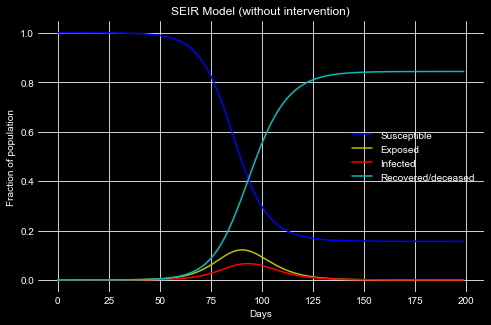

In [28]:
T_inc = 5.2  # average incubation period
T_inf = 2.9  # average infectious period
R_0 = 2.2  # reproduction number

sol = solve_ivp(SEIR_model, [0, max_days], [a, b, c, d], args=(R_0, T_inf, T_inc), 
                t_eval=np.arange(max_days))

plot_model(sol, 'SEIR Model (without intervention)')

## Fitting with real data - NYC


In [91]:
# Fetch data from NYC
! rm time_series_covid19_deaths_US.csv*
! wget -nv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv

raw_data_us = pd.read_csv("time_series_covid19_deaths_US.csv")
start_date = datetime.date(2020, 1, 22)
date_format = "%-m/%-d/%y"

# Extract NYC time_series data
deaths_time_series_nyc = []
date = deepcopy(start_date)
df_nyc = raw_data_us[raw_data_us['Combined_Key'].str.contains("New York City")]
df_nyc_cols = df_nyc.columns.values

while date.strftime(date_format) in df_nyc_cols:
    deaths_time_series_nyc.extend(df_nyc[date.strftime(date_format)].values)
    date = date + datetime.timedelta(days=1)

deaths_time_series_nyc = np.array(deaths_time_series_nyc)
deaths_time_series_nyc[1:] = np.diff(deaths_time_series_nyc)

2020-05-26 23:34:23 URL:https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv [1177355/1177355] -> "time_series_covid19_deaths_US.csv" [1]


In [109]:
def smoothen(X, std):
    result = np.zeros_like(X)
    
    for i, _ in enumerate(X):
        norm_factor = 0
        for j, _X in enumerate(X):
            val = norm.pdf(j, loc=i, scale=std)
            result[i] += _X * val
            norm_factor += val
        result[i] /= norm_factor
    
    return result

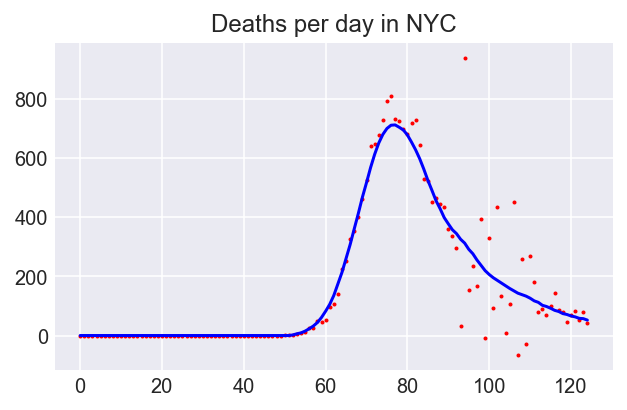

In [118]:
smoooth_data_nyc = smoothen(deaths_time_series_nyc, 3)

plt.figure(figsize=(5,3))
plt.scatter(np.arange(smoooth_data_nyc.shape[0]), deaths_time_series_nyc, label="Raw data", s=1, c='red')
plt.plot(smoooth_data_nyc, label="Smoothened data", c='blue')
plt.title("Deaths per day in NYC")
plt.show()